# Demystifying SARIMA Models

Last week I finished a project where I identified the five zip codes in the city of Baltimore, Maryland where an individual would expect the highest return on investment for buying a house, living in the house, then reselling after two years. You can check out my github repository for the project [here](https://github.com/sethchart/Baltimore-Real-Estate-Investment). In that project, I used Seasonal AutoRegressive Integrated Moving Average (SARIMA) models to forecast house prices based on historical data that I collected from Zillow.

In this post I want to take a closer look at these powerful time series models and try to get some intuition for how they work. A SARIMA model is a fairly complex type of time series model that combines several ideas to provide a flexible framework for modeling time series data. I want to build up the full model slowly and step-by-step so we can get an idea of how each additional piece contributes to the full model.

## What is a time series?

First thing's first, what kind of data are we trying to model? Time series data. What does that mean? How about a few examples.

### Example 1 

Suppose that you are using a workout app and every morning you weigh yourself and record your weight in the app. The list of all of your weights is a time series. The list of weights represents the history of your weight over a period of time, measured at regular time intervals. 

### Example 2 

Suppose that you record the total amount of money that you spend at the end of each month. The list of expenditures is a time series. The list represents the history of your spending over a period of time, measured at regular time intervals. 

### Definition 

Given one measurable quantity, a time series is a list of measurements of that quantity taken at regular time intervals.

## Recurrence Relations

A time series is fundamentally a list of numbers. The list below are weights from my own fitness tracker app collected every morning starting on 2020-11-16 and ending on 2020-11-22. 

In [2]:
weights = [172.6, 172.6, 172.1, 171.7, 172.6, 171.0, 172.8]

Mathematicians like to use compact notation for lists like the one above. A mathematician might call the list above $w$. Then, they would refer to the very first number in the list by the name $w_0$, so $w_0 = 172.6$. This is pretty similar to the way we work with this list in python. If we want the first number in the list, we type `weights[0]` which returns 172.6. The function below lists out all of the numbers in the weights list with both mathematical notation and python syntax.

In [10]:
from IPython.display import display, Markdown
def print_weights():
    for k in range(len(weights)):
        display(Markdown(f"$w_{k}$ = weights[{k}] = {weights[k]}"))
        
print_weights()

$w_0$ = weights[0] = 172.6

$w_1$ = weights[1] = 172.6

$w_2$ = weights[2] = 172.1

$w_3$ = weights[3] = 171.7

$w_4$ = weights[4] = 172.6

$w_5$ = weights[5] = 171.0

$w_6$ = weights[6] = 172.8

One common way to describe a list of numbers is by providing an equation that allows you to compute a new value of the list using previous values of the list. Usually we need to provide the equation and a few values to get the ball rolling. Let's look at a couple of classic examples.

### Example 3
The equation below says that for any whole number $n$ that is greater than or equal to one, the $n$th value in my list is just two times the previous ($(n-1)$st) value in the list.

$$a_n = 2a_{n-1} \text{ for } n \ge 1, a_0 = 1.$$

We are also given a value ($a_0 = 1$) to get the ball rolling. We can compute the first couple of values by hand:

$n = 1$ is greater than or equal to one, so our equation tells us that:

$$a_1 = 2a_0$$

But we were given $a_0 = 1$, so we see that:

$$a_1 = 2(1) = 2$$

Now that we know $a_1$ let's compute $a_2$.

$$a_2 = 2 a_1$$

But we know that $a_1 = 2$, so we get can compute.

$$a_2 = 2(2) = 4$$

But, why do math by hand in a python notebook. Let's check out the first ten values in this list $a$.

In [21]:
import numpy as np
def compute_sequence(coefficients, initial_conditions, n_values):
    order = len(coefficients)
    sequence = initial_conditions
    while len(sequence) <= n_values:
        tail = sequence[-order:][::-1]
        new_value = np.dot(tail, coefficients)
        sequence.append(new_value)
    return sequence

compute_sequence(coefficients=[2], initial_conditions=[1], n_values=10)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

As you can see the equation above describes the powers of two.

### Example 4
See if you can compute the first ten values in the list described by the equation below. 

$$ f_n = f_{n-1} + f_{n-2} \text{ for } n\ge 2, f_0 = 1\; \text{ and } f_1 = 1.$$

Now, check your answer by running the cell below.

In [22]:
compute_sequence(coefficients=[1, 1], initial_conditions=[1, 1], n_values=10)

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]

This is a pretty famous example find out more [here](https://en.wikipedia.org/wiki/Fibonacci_number).

The equations that we used in the examples above are called **Linear Recurrence Relations**. 

### Definition
A **Linear Recurrence Relation** of *order* $k$ with *coefficients* $c_1, c_2, ..., c_{k}$ and *initial conditions* $i_0, i_1, ..., i_{k-1}$ is an equation of the form

$$ a_n = c_1 a_{n-1} + c_2 a_{n-2} + ... + c_{k} a_{n-k} \text{ for } n \ge k, a_0 = i_0, a_1 = i_1, ..., a_{k-1} = i_{k-1}.$$

The equation describes a list of values also commonly called as *sequence*.

### Example 5

Below we plot the first ten values of the Linear Recurrence Relation of order 2 with coefficients $c_1 = 1, c_2 = -\tfrac{1}{2}$, and and initial conditions $a_0 = -3$ and $a_1 = 1$. This can be written as the equation below.

$$ a_n = (1)a_{n-1} + \left(-\tfrac{1}{2}\right)a_{n-2} \text{ for } n \ge 2, a_0 = -3, a_1 = 1. $$

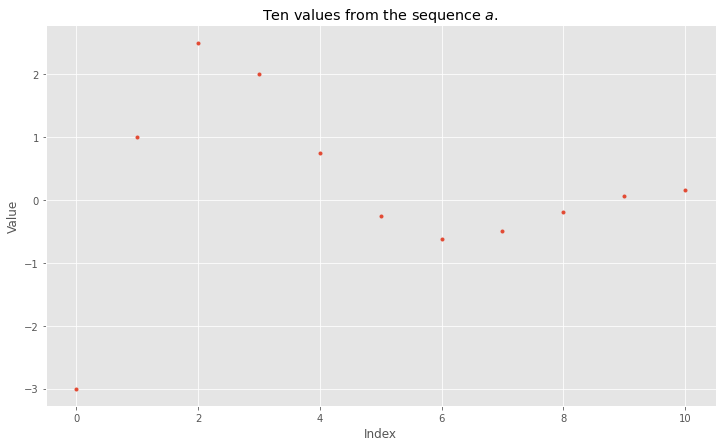

In [23]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
seq = compute_sequence(coefficients=[1, -1/2], initial_conditions=[-3, 1], n_values=10)
plt.figure(figsize=(12,7));
plt.plot(seq, '.');
plt.title("Ten values from the sequence $a$.");
plt.xlabel("Index");
plt.ylabel("Value");

## Autoregressive models

Recurrence relations are a fantastic way to describe a list of numbers, but you might notice that they are pretty rigid. Once you know a few values to get the ball rolling, you can find as many values of your list as you want by doing some simple arithmetic. 

If we are thinking about a time series, like my weight in my fitness app, I definitely don't expect to find a formula that would let me take the first couple of weights and compute my exact weight, ten, twenty, or three hundred and sixty five days in the future. I would expect to be able to identify some general trend and forecast my weight a a few days into the future. But I would also expect to see quite a bit of variation day-to-day. There are all sorts of external factors that affect my weight day-to-day that I can not infer from a list of weights that I have measured in the past. How much I have been moving, how much I have been eating, how much water I have been drinking, how much I have been sleeping, these are all factors that affect my daily weight measurements. I am no expert, but I assume that there are myriad other complex biological processes and variations that also have small day-to-day effects on my weight.

The point here is that while a recurrence relation is a useful way to describe a list of numbers, when we think about time series data, we would expect that there are external factors that influence the values in the time series that cannot be known by just knowing the past values of the time series. 

Mathematicians have a standard trick for analyzing problems where parts of the problem are unknown or unknowable. Throw in some randomness! That is what we are going to do here. We will take our recurrence relation idea and add a little randomness. 

### Example 6

Let's take the recurrence relation from Example 5 and modify it by adding a random number $r_n$ each time we compute a new value. 

$$ a_n = (1)a_{n-1} + \left(-\tfrac{1}{2}\right)a_{n-2} + r_n \text{ for } n \ge 2, a_0 = -3, a_1 = 1. $$

The idea is that when I compute a new value in my list, I do the same arithmetic that I did be for, but then I add a random number that represents the effects of all of the unknown or unknowable external factors that influence the time series that I want to model. 